In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [16]:
from fastai.text import *
import pickle
import pandas as pd
import sentencepiece as spm

In [3]:
PATH=Path('/home/paperspace/data/mimic-iii')
LM_PATH=PATH/'exp-3'

In [4]:
trn_ids = np.load(LM_PATH/'trn_ids_concat.npy')
val_ids = np.load(LM_PATH/'val_ids_concat.npy')

In [5]:
vocab_size=30000

In [6]:
em_sz,nh,nl = 400,1150,3
bptt, bs = 70, 64

In [7]:
trn_dl = LanguageModelLoader(trn_ids, bs, bptt)
val_dl = LanguageModelLoader(val_ids, bs, bptt)
md = LanguageModelData(PATH, 0, vocab_size, trn_dl, val_dl, bs=bs, bptt=bptt)

In [8]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.5

In [9]:
opt_fn = partial(optim.Adam, betas=(0.8,0.99))
learner= md.get_model(opt_fn, em_sz, nh, nl,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1e-7

In [ ]:
learner.lr_find(end_lr=1000)

In [ ]:
learner.sched.plot()

In [10]:
lr = 10e-4

In [11]:
learner.fit(lr, 1, cycle_len=10, use_clr_beta=(10,10,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                         
    0      2.918691   2.884782   0.479281  
    1      2.610951   2.543407   0.514165                         
    2      2.488604   2.427246   0.526632                         
    3      2.446519   2.364894   0.534882                         
    4      2.367158   2.314849   0.542186                         
    5      2.340279   2.26538    0.549559                         
    6      2.297407   2.22772    0.55526                          
    7      2.260481   2.197222   0.5599                           
    8      2.228313   2.174836   0.563446                         
    9      2.213755   2.166181   0.564879                         



[array([2.16618]), 0.5648794928166092]

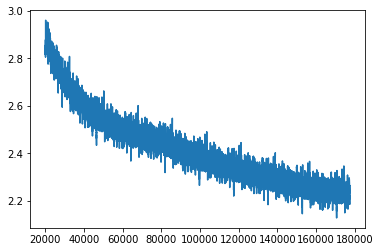

In [12]:
learner.sched.plot_loss(n_skip=20000)

In [13]:
learner.save('experiment-3-sentence-piece-lowercase')

In [ ]:
learner.load('experiment-2-sentence-piece-lowercase')

In [108]:
m = learner.model

sp = spm.SentencePieceProcessor()
sp.Load("sp.model")

def sample_model(m, s, l=100):
    words = []
    
    s_nums = sp.EncodeAsIds(s)
    s_var = V(np.array(s_nums))[None]

    m[0].bs=1
    m.eval()
    m.reset()

    res, *_ = m(s_var)
    print('...', end='')

    for i in range(l):
        r = torch.multinomial(res[-1].exp(), 2)
        #r = torch.topk(res[-1].exp(), 2)[1]
        if r.data[0] == 0:
            r = r[1]
        else:
            r = r[0]
        words = words + [int(to_np(r)[0])]
        res, *_ = m(r[0].unsqueeze(0))
        #print(word, end=' ')
    m[0].bs=bs
    print(sp.DecodeIds(words))

In [132]:
s = 'cardiovascular system '
sample_model(m, s)

...evaluated by dr. [**first name8 (namepattern2) **] [**last name (namepattern1) vits.033**] responded well to iv diuretics. pt. has been increasingly hypotensive throughout the [**last name (lf) **], [**first name3 (lf) 116**] restart initiation of dobutamine. would let patient [**2175**] but would like to reconsult and clots tried because left ij was infected (would insert ibuprofen to treat lower groin site). iv nurse's patent and were d/cd. given ngt to a 20 cm


In [151]:
s = 'blood loss '
sample_model(m, s)

...of unclear etiology. full codeall: nkdameds: senna, senna, digoxin, asa / sc heparin,les, lisinopril, nystatindischarge medications:1. cholecalciferol (vitamin d3) 400 unit tablet sig: one (1)tablet po daily (daily).2. piperacillin-tazobactam 2.25 g recon soln sig: four hundred (500) mg intravenous q12h (every 12 hours) for 5 days.disp:*6 * refills:*0*3. docusate sodium 100 mg capsule sig
